---
format: 
  html:
    toc: true
execute:
  echo: true
  code-fold: true
---

# Exploratory Spatial Data Analysis

This section will explore some of the key demographic data of Pennsylvania spatially. It will identify spatial clustering and other patterns through maps, a correlation matrix, and a scatter plot.

In [1]:
#| echo: false
# This chunk is hidden on the webiste. It just reloads the pa_counties dataframe in this notebook.
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

API_KEY = '0da0c882151e10740c1a0a844cf845096bedb565'
c = Census(API_KEY)

acs_data = c.acs5.state_county(
    fields=[
        'NAME',         # County name
        'B01003_001E',  # Total population
        'B15003_001E',  # Population 25+
        'B19013_001E',  # Median household income
        'B19301_001E',  # Per capita income
        'B01002_001E',  # Median age
        'B02001_002E',  # White population
        'B02001_003E',  # African American population
        'B03001_003E',  # Hispanic population
        'B15003_017E',  # High school graduates
        'B15003_022E',  # Bachelor’s degree holders
        'B25077_001E',  # Median housing value
        'B17001_002E',  # Population below poverty line
    ],
    state_fips=states.PA.fips,
    county_fips="*"
)

acs_df = pd.DataFrame(acs_data)
acs_df.columns = [
    'County',  # Name of the county
    'Total Population',
    'Population Over 25',
    'Median Household Income', 
    'Per Capita Income', 
    'Median Age', 
    'White Population', 
    'African American Population', 
    'Hispanic Population', 
    'High School Graduates', 
    'Bachelors Degree Holders', 
    'Median Housing Value', 
    'Population Below Poverty Line',
    'State',  
    'County_Name'
]

acs_df['County'] = acs_df['County'].str.replace(" County, Pennsylvania", "", case=False)
acs_df['County'] = acs_df['County'].str.upper()
acs_df.drop(columns=['State'], inplace=True)

geojson_path = "/Users/ryanswett/Downloads/Python/Final_Project/PaCounty2024_11.geojson"
county_data = gpd.read_file(geojson_path)
counties = county_data.merge(
    acs_df,
    left_on='FIPS_COUNT',
    right_on='County_Name',
    how='left'
)

counties['Percent_White'] = counties['White Population'] / counties['Total Population']*100 # Percent white
counties['Percent_Black'] = counties['African American Population'] / counties['Total Population']*100 # Percent black
counties['Percent_Hispanic'] = counties['Hispanic Population'] / counties['Total Population']*100 # Percent hispanic
counties['Percent_HS_degrees'] = counties['High School Graduates'] / counties['Total Population']*100 # Percent high school grads
counties['Percent_Bachelors'] = counties['Bachelors Degree Holders'] / counties['Population Over 25']*100 # Percent bachelors
counties['Percent_Poverty'] = counties['Population Below Poverty Line'] / counties['Population Over 25']*100 # Percent below poverty line

parks_path = "/Users/ryanswett/Downloads/Python/Final_Project/DCNR_LocalPark202406/DCNR_LocalPark202406.shp"
parks_data = gpd.read_file(parks_path)

parks_data = parks_data.drop(columns=['STATUS', 'PARK_FEE', 'ALT_NAME', 'PREMISE_AD', 'PREMISE_CI', 'PREMISE_ZI', 'YEAR_OPEN',
                                     'PREMISE_CR', 'URL', 'COMMENTS', 'ATV', 'Basketball', 'Bicycling', 'Camping', 'Canoeing_K',
                                     'CrossCount', 'Disc_Golf', 'Dog_Park', 'Equestrian', 'Fishing', 'Fitness_Eq', 'Golf',
                                     'Hiking', 'Horseback_', 'Hunting', 'Ice_Fishin', 'Ice_Skatin', 'Motor_Boat', 'LWCF_Restr',
                                     'Mountain_B', 'Natural_Wi', 'Organized_', 'Parking', 'Pavilion', 'Pets_Allow', 'Playground',
                                     'Restrooms', 'Rock_Climb', 'Scenic_Vie', 'Sledding', 'Sports_Fie', 'Swimming', 'Tennis_Cou',
                                     'Theatre_Am', 'Trails', 'Visitor_Ce', 'White_Wate', 'Wildlife_W', 'Amenity_Co', 'Feedback_l',
                                     'Skate_Park'])

updated_parks = parks_data.groupby('PREMISE_CO')['Acres'].sum().reset_index()
updated_parks['park_sq_mi'] = updated_parks['Acres'] / 640
updated_parks['PREMISE_CO'] = updated_parks['PREMISE_CO'].str.upper()

parks = counties.merge(
    updated_parks,
    left_on='County',  
    right_on='PREMISE_CO',  
    how='left')

parks['Percent Local Park'] = parks['park_sq_mi'] / parks['AREA_SQ_MI'] * 100

unemp_data = pd.read_csv("/Users/ryanswett/Downloads/Python/Final_Project/unemp.csv")
unemp_data['County'] = unemp_data['County'].str.replace('County', '', case=False).str.strip()
unemp_data['County'] = unemp_data['County'].str.upper()

pa_counties = unemp_data.merge(
    parks,
    left_on='County', 
    right_on='County', 
    how='left')

pa_counties.rename(columns={"Value (Percent)": "Unemp Rate"}, inplace=True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


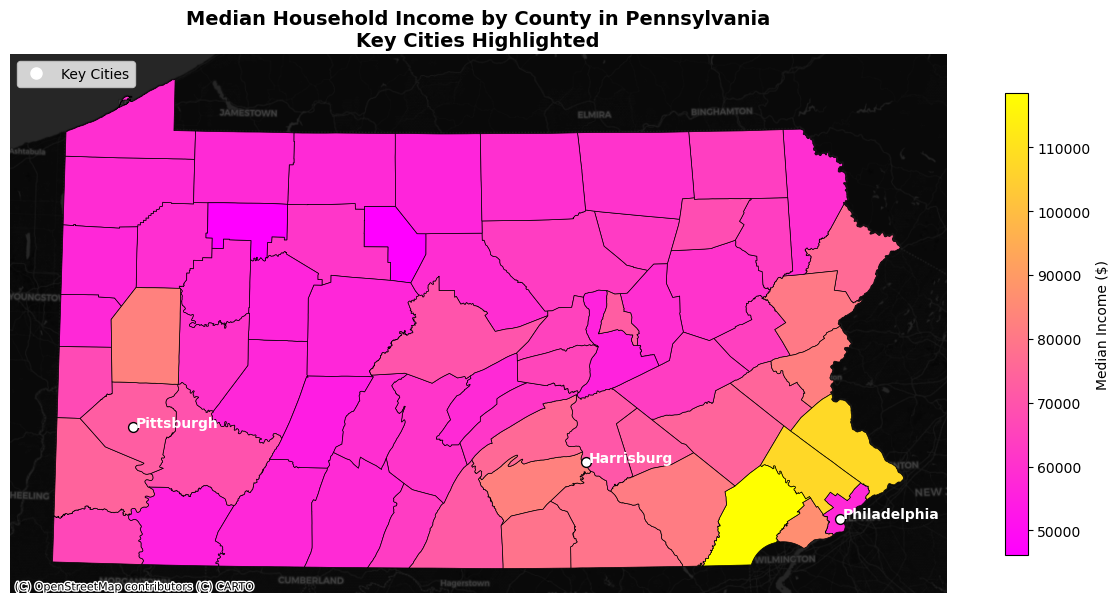

In [2]:
#| echo: true
#| code-fold: true
pa_counties = gpd.GeoDataFrame(pa_counties, geometry=pa_counties['geometry'])
pa_counties = pa_counties.to_crs(epsg=2272)
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

norm = Normalize(vmin=pa_counties['Median Household Income'].min(), vmax=pa_counties['Median Household Income'].max())
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Median Household Income',
    cmap='spring',  
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Median Income ($)"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
plt.title("Median Household Income by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()

This first visualization highlights the median household income by county. Counties located nearby major cities tend to have higher median incomes than other counties. Specifically, counties near Philadelphia tend to have the highest medan income overall.

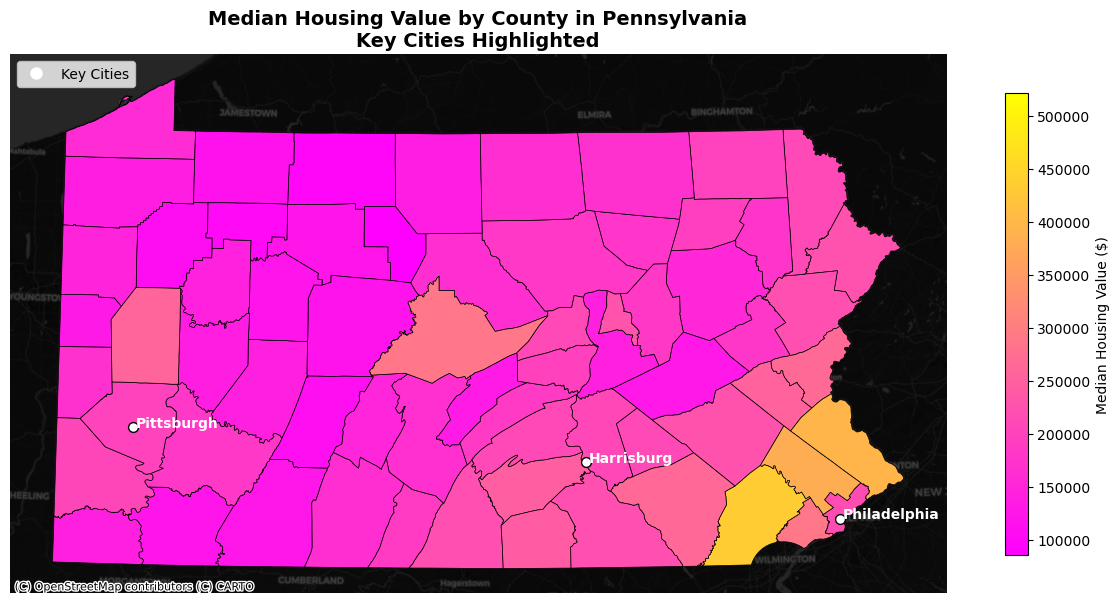

In [3]:
#| echo: true
#| code-fold: true
pa_counties = pa_counties.to_crs(epsg=2272)

key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

norm = Normalize(vmin=pa_counties['Median Housing Value'].min(), vmax=pa_counties['Median Housing Value'].max() * 1.2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Median Housing Value',
    cmap='spring',  
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Median Housing Value ($)"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Median Housing Value by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")


plt.tight_layout()
plt.show()

Median housing value tends to be similar to median household income by county in Pennsylvania. Like median household income, median housing value tends to be higher in counties that are located nearby key Pennsylvania cities. There appears to be slight clustering in this map as well.

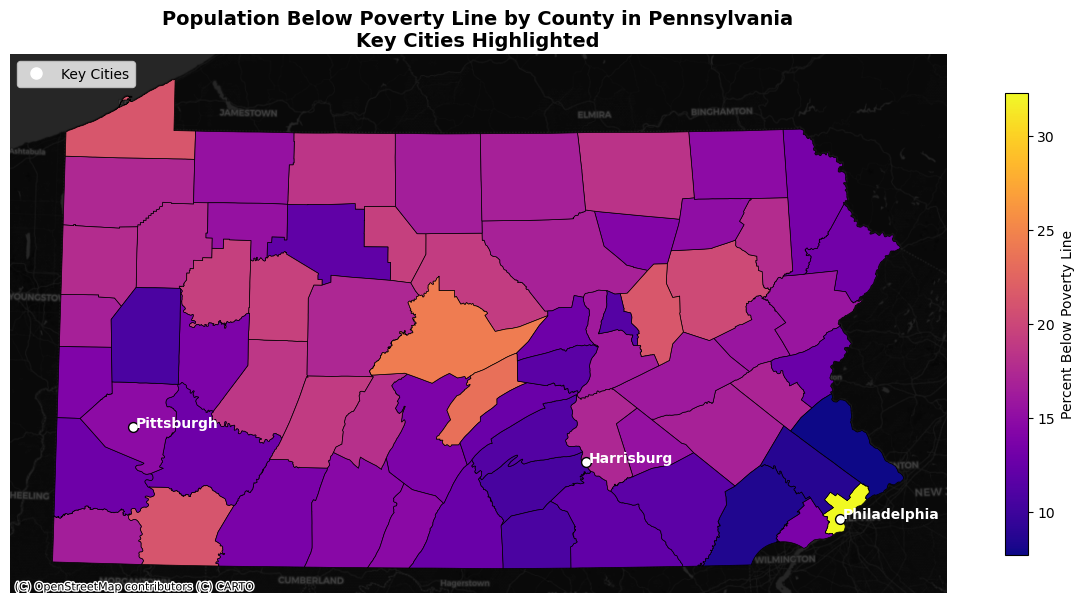

In [4]:
#| echo: true
#| code-fold: true
pa_counties = pa_counties.to_crs(epsg=2272)
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

norm = Normalize(vmin=pa_counties['Percent_Poverty'].min(), vmax=pa_counties['Percent_Poverty'].max())
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Percent_Poverty',
    cmap='plasma',  
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent Below Poverty Line"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Population Below Poverty Line by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

plt.tight_layout()
plt.show()

Philadelphia county has the highest percentage of people living below the poverty line. However, Philadelphia's surrounding counties have the lowest. The rest of Pennsylvania does not seem to have a clear spatial pattern in terms of population living below the poverty line.

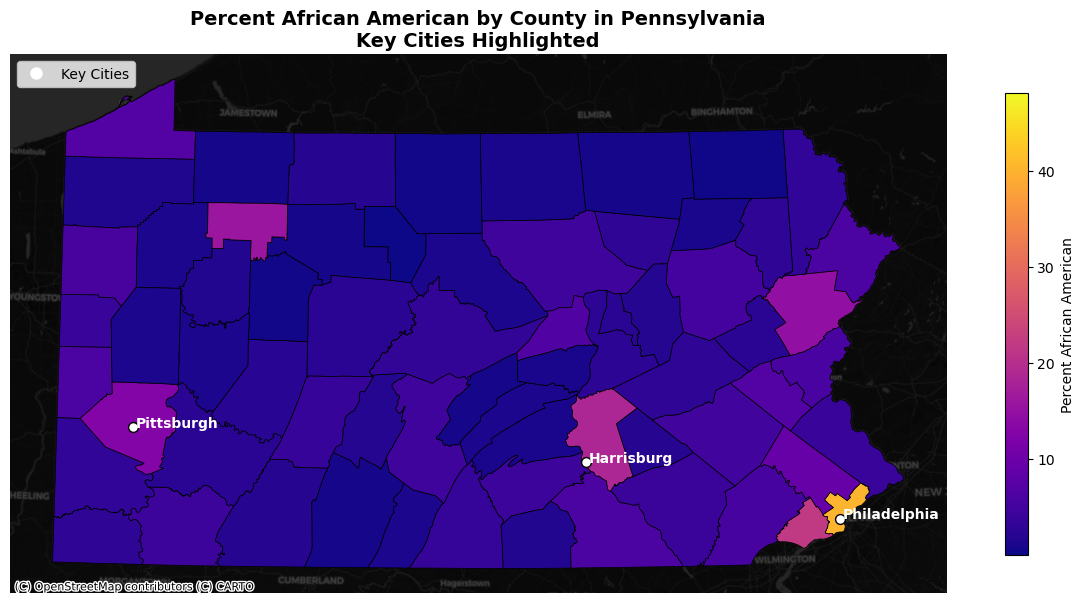

In [5]:
#| echo: true
#| code-fold: true
pa_counties = pa_counties.to_crs(epsg=2272)

key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

norm = Normalize(vmin=pa_counties['Percent_Black'].min(), vmax=pa_counties['Percent_Black'].max() * 1.2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Percent_Black',
    cmap='plasma',  
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent African American"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Percent African American by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

plt.tight_layout()
plt.show()

This map shows that the counties with the highest proportion of African Americans are nearby key cities in the state. The three counties where Philadelphia, Harrisburg, and Pittsburgh are located have some of the highest percentages of African Americans. There is a smaller proportion of African Americans clustered throughout most of the rest of the state.

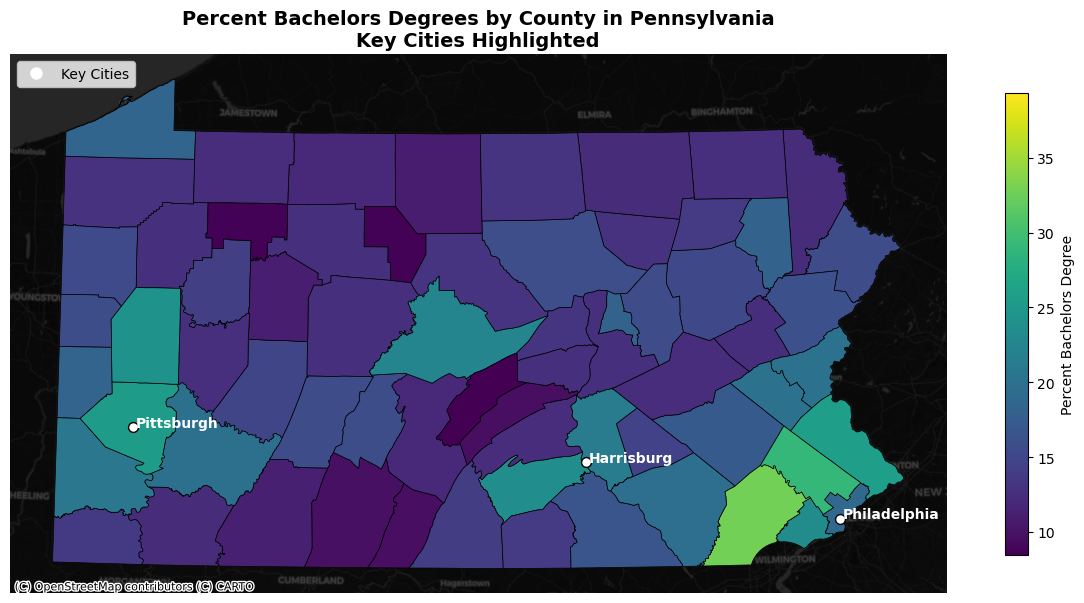

In [6]:
#| echo: true
#| code-fold: true
pa_counties = pa_counties.to_crs(epsg=2272)

key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

norm = Normalize(vmin=pa_counties['Percent_Bachelors'].min(), vmax=pa_counties['Percent_Bachelors'].max() * 1.2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Percent_Bachelors',
    cmap='viridis',  
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent Bachelors Degree"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Percent Bachelors Degrees by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

plt.tight_layout()
plt.show()

Similar to the visualizations with median housing value and income, the counties with a higher proportion of individuals who have Bachelors degrees seems to be in and around counties that have a major city. High education levels seem to be clustered in southeastern Pennsylvania near Philadelphia. This could be due in part to the colleges in this region of the state.

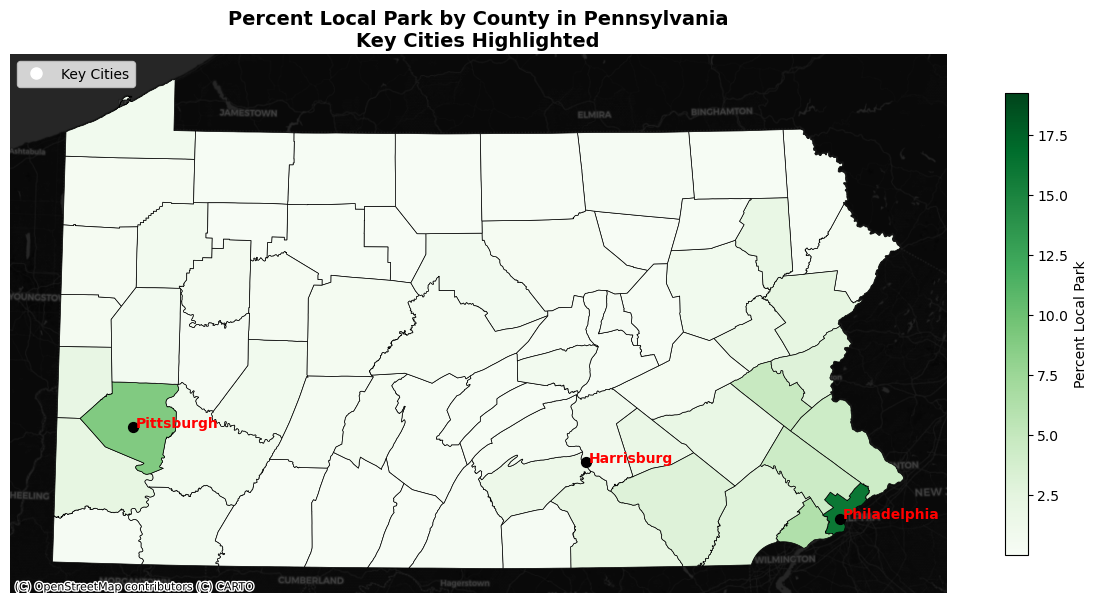

In [7]:
#| echo: true
#| code-fold: true
pa_counties = pa_counties.to_crs(epsg=2272)

key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

norm = Normalize(vmin=pa_counties['Percent Local Park'].min(), vmax=pa_counties['Percent Local Park'].max() * 1.2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Percent Local Park',
    cmap='Greens', 
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent Local Park"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='black', markersize=50, edgecolor='black', label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='red', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Percent Local Park by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

plt.tight_layout()
plt.show()

Although many of the counties toward the middle of the state have a large amount of green space, many lack a supply of public parks for residents to enjoy for free. However, Philadelphia and Pittsburgh are located in counties where a higher proportion of the county is made up of these accesible green spaces.

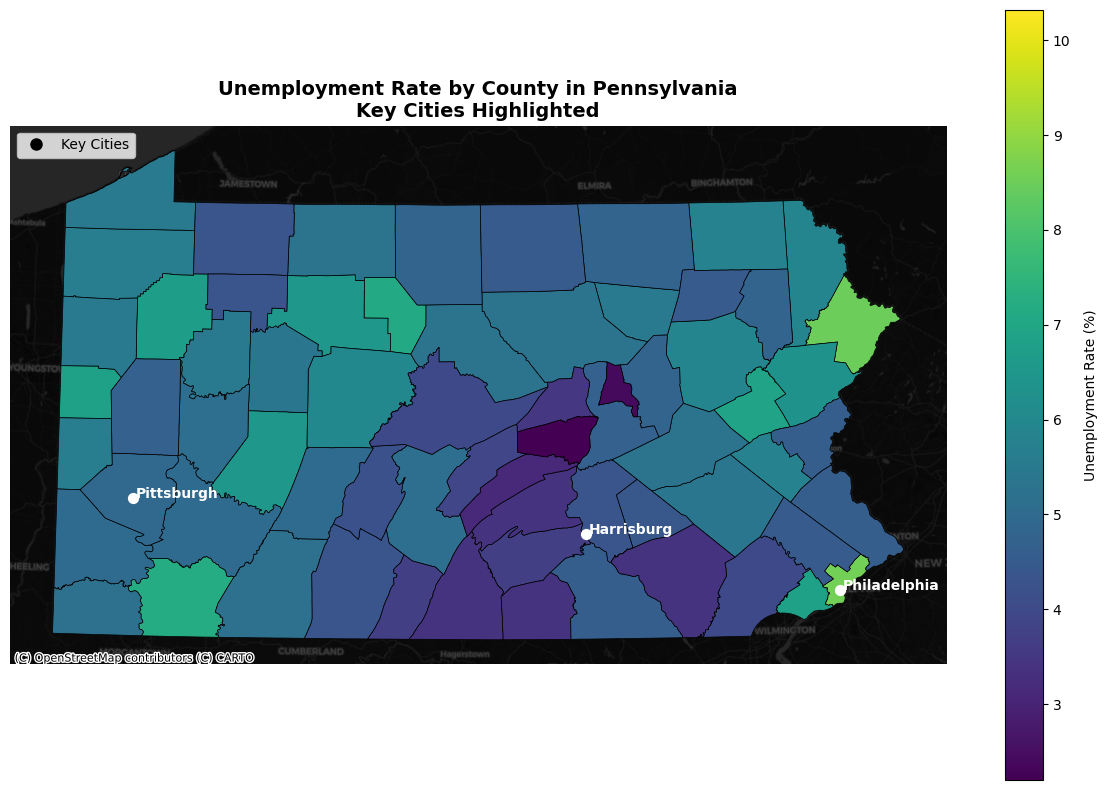

In [8]:
#| echo: true
#| code-fold: true
pa_counties = pa_counties.to_crs(epsg=2272)

key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

min_unemp = pa_counties['Unemp Rate'].min()
max_unemp = pa_counties['Unemp Rate'].max()
norm = Normalize(vmin=min_unemp, vmax=max_unemp * 1.2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Unemp Rate',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5,
    legend=False,
    norm=norm,
    ax=ax
)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Unemployment Rate (%)", fontsize=10, labelpad=10)

cities_gdf.plot(ax=ax, color='white', markersize=50, label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)
legend_elements = [Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Unemployment Rate by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

plt.tight_layout()
plt.show()

Unemployment rate appears to be slightly clustered in the state. For example, low unemployment seems to be common west of Harrisburg with higher levels of unemployment farther west nearby Pittsburg. It is unclear what this trend may indicate about the state now. Philadelphia County has a disproportiontely large unemployment rate.

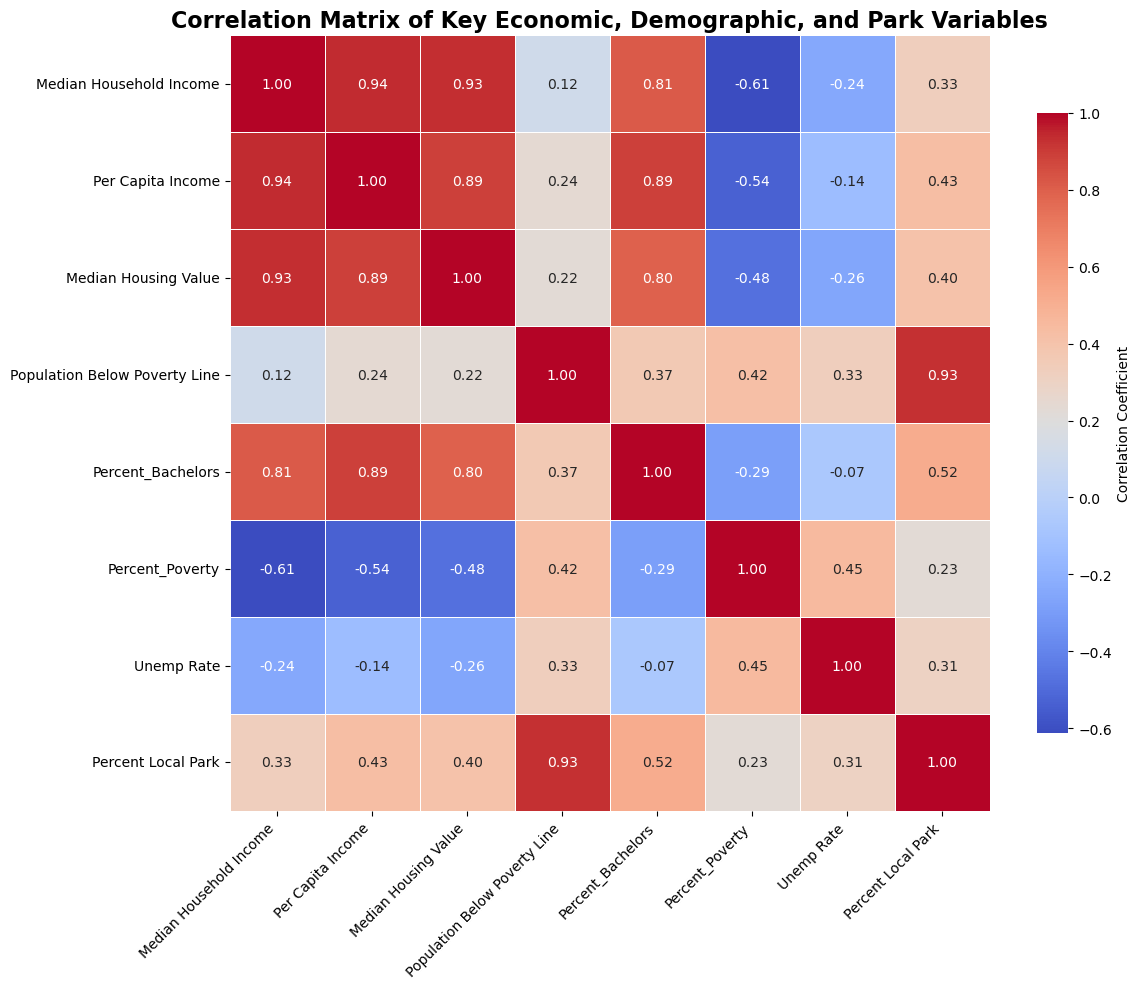

In [9]:
#| echo: true
#| code-fold: true
import seaborn as sns
import matplotlib.pyplot as plt

refined_vars = [
    'Median Household Income',
    'Per Capita Income',
    'Median Housing Value',
    'Population Below Poverty Line',
    'Percent_Bachelors',
    'Percent_Poverty',
    'Unemp Rate',
    'Percent Local Park'
]

refined_correlation_matrix = pa_counties[refined_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    refined_correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)
plt.title("Correlation Matrix of Key Economic, Demographic, and Park Variables", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

This correlation matrix provides a valuable foundation for identifying areas in Pennsylvania where government resources and policies can be more effectively allocated.

Strong Positive Relationships Between Income and Education:

- Median Household Income and Percent Bachelors show a strong positive correlation (0.81). This suggests that areas with higher levels of educational attainment tend to have higher household incomes. Policies that promote access to higher education, such as scholarships or workforce training programs, could uplift communities with lower incomes.

- Per Capita Income also correlates positively with Percent Bachelors (0.89), reinforcing this connection.

Inverse Relationship Between Poverty and Income:

- Percent Poverty has a negative correlation with Median Household Income (-0.61) and Per Capita Income (-0.54). Areas with higher poverty rates are likely to have lower incomes. These areas may need targeted economic development programs, job creation initiatives, or social safety nets to reduce poverty levels.

Unemployment and Poverty:

- Unemployment Rate correlates positively with Percent Poverty (0.45) and negatively with income measures (e.g., -0.26 with Median Household Income). High unemployment exacerbates poverty and income disparities. Job training programs and economic revitalization efforts could be prioritized in high-unemployment areas.

Park Accessibility and Socioeconomic Indicators:

- Percent Local Park has a modest positive correlation with Median Household Income (0.33) and Per Capita Income (0.43). This suggests that areas with better park access might also have higher incomes, potentially due to historical investment patterns. Expanding park and recreational opportunities in underserved areas could address inequities and improve quality of life.

Focus on Areas of High Poverty and Low Education:

- Percent Poverty and Population Below Poverty Line are positively correlated (0.42), highlighting a clear need to target these areas. Additionally, Percent Bachelors has a weaker correlation with poverty measures, indicating that educational access might be a key intervention point.

Housing Value as a Proxy for Wealth:

- Finally, median housing value correlates strongly with Median Household Income (0.93) and Percent Bachelors (0.80). Housing value could serve as a proxy for identifying wealthier versus underserved areas. Policies could focus on improving housing affordability in high-poverty regions.

	
Actionable Insights for Policy Implementation:


Target High-Poverty, Low-Education Areas:

- Use this correlation matrix to identify counties with high poverty rates and low levels of educational attainment. Allocate resources to provide educational programs and improve access to higher education in these regions.

Expand Parks and Recreational Resources:

- The modest correlation between park access and income highlights the potential for parks to serve as equitable community investments. Focus on areas with limited park access to enhance quality of life and public health.

Job Training and Economic Development:

- Address high unemployment areas by investing in job training and economic opportunities. This can help reduce poverty rates and improve overall economic conditions.

Consider Housing Affordability:

- Explore housing initiatives in areas where Median Housing Value is low but Percent Poverty is high. This might indicate regions where housing needs renovation or redevelopment.


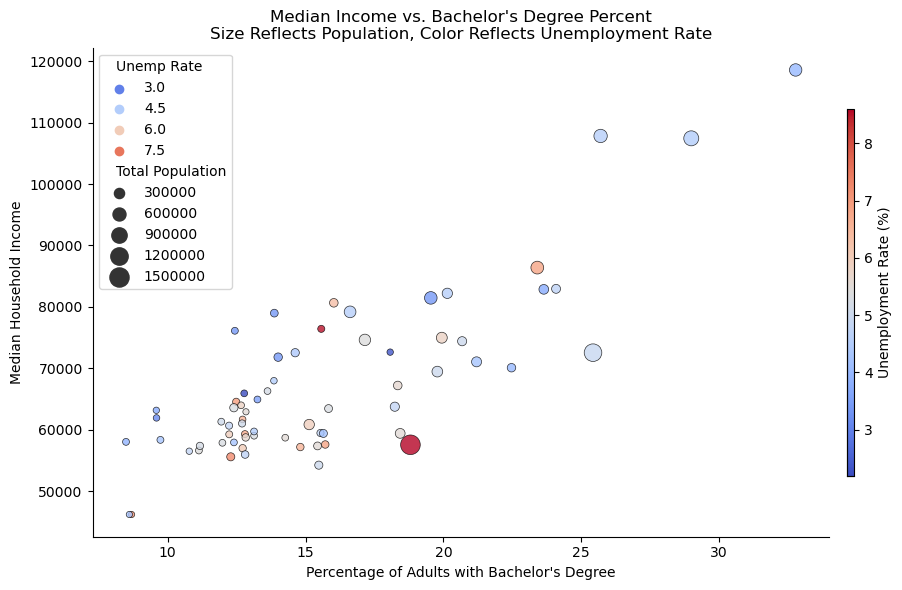

In [10]:
#| echo: true
#| code-fold: true
fig, ax = plt.subplots(figsize=(10, 6))

scatter = sns.scatterplot(
    data=pa_counties, 
    x='Percent_Bachelors', 
    y='Median Household Income', 
    size='Total Population', 
    hue='Unemp Rate',  
    palette='coolwarm', 
    sizes=(20, 200),  
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8, 
    ax=ax
)

norm = plt.Normalize(pa_counties['Unemp Rate'].min(), pa_counties['Unemp Rate'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, aspect=50, shrink=0.75, pad=0.02)
cbar.set_label("Unemployment Rate (%)")

plt.title("Median Income vs. Bachelor's Degree Percent\nSize Reflects Population, Color Reflects Unemployment Rate")
plt.xlabel("Percentage of Adults with Bachelor's Degree")
plt.ylabel("Median Household Income")

sns.despine()

plt.tight_layout()
plt.show()

This scatterplot provides insights into the relationships between median household income, percentage of adults with a bachelor’s degree, unemployment rate, and total population at the county level in Pennsylvania. Here’s what this visualization reveals for the analysis:


Median Income vs. Bachelor’s Degree Attainment:

- Counties with higher percentages of adults holding a bachelor’s degree generally show higher median household incomes. This suggests a strong positive relationship between educational attainment and income levels across Pennsylvania counties.
    
- Some outliers exist where counties with relatively high education levels still have lower median incomes, indicating other influencing factors like industry structure or cost of living.

    
Unemployment Rate (Color Gradient):
    
- The color gradient, ranging from blue (lower unemployment) to red (higher unemployment), highlights that counties with higher bachelor’s degree attainment tend to have lower unemployment rates.
    
- Counties with higher unemployment rates (darker red points) are concentrated in areas with lower income and bachelor’s degree percentages, emphasizing a need for policy interventions in these regions.
    
Population Distribution (Bubble Size):
    
- The bubble size represents the total population of each county. Larger counties (e.g., Philadelphia) are concentrated in regions with relatively higher income and education levels but may also face unique challenges.
    
- Smaller counties are scattered across the spectrum, with varying levels of income, education, and unemployment, indicating that population size alone does not dictate economic outcomes.

Implications for Policy:

- Education and Income: There is a clear need to invest in education as a means to improve median household income. Counties with lower bachelor’s degree attainment could benefit from initiatives to expand access to higher education and workforce development programs.
    
- Unemployment Interventions: Counties with high unemployment rates and lower educational attainment should be prioritized for job creation programs and retraining initiatives.
    
- Resource Allocation: Larger counties with significant population sizes should not overshadow smaller counties in resource allocation, as many smaller counties face substantial challenges in income, education, and employment.
    
- Outliers: Policymakers should also focus on outliers where high educational attainment does not translate into higher income or employment, identifying and addressing structural barriers in these regions.

Overall, this visualization reinforces the interconnectedness of income, education, and employment and provides a data-driven foundation for equitable resource allocation across Pennsylvania.

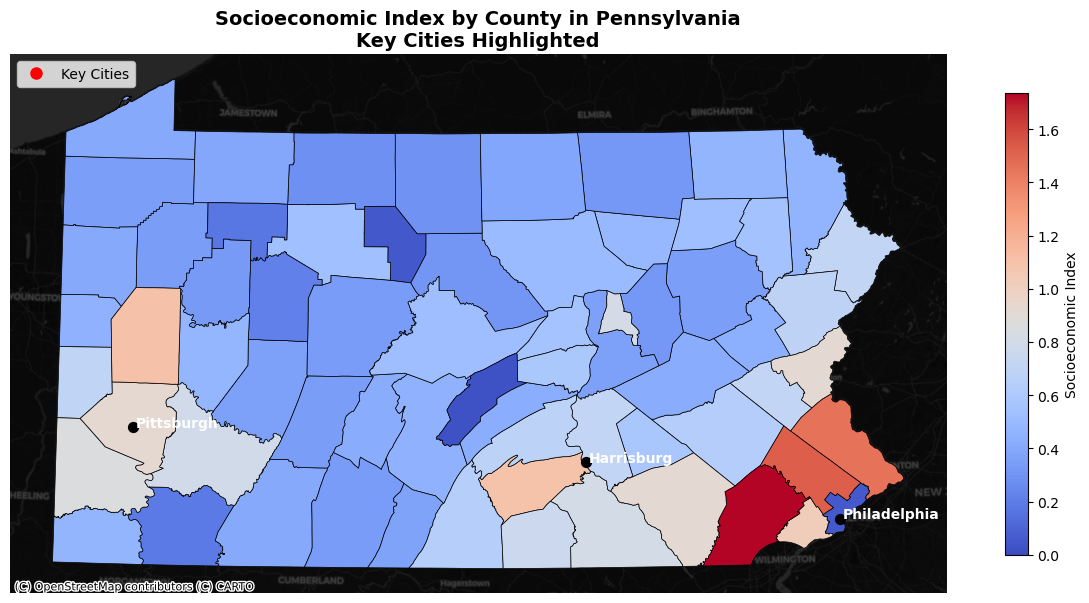

In [11]:
#| echo: true
#| code-fold: true
pa_counties['Median Household Income'] = pd.to_numeric(pa_counties['Median Household Income'], errors='coerce')
pa_counties['Percent_Bachelors'] = pd.to_numeric(pa_counties['Percent_Bachelors'], errors='coerce')
pa_counties['Percent_Poverty'] = pd.to_numeric(pa_counties['Percent_Poverty'], errors='coerce')
pa_counties['Median Household Income'].fillna(0, inplace=True)
pa_counties['Percent_Bachelors'].fillna(0, inplace=True)
pa_counties['Percent_Poverty'].fillna(0, inplace=True)

scaler = MinMaxScaler()
variables = pa_counties[['Median Household Income', 'Percent_Bachelors', 'Percent_Poverty']].copy()
variables = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)

pa_counties['Socioeconomic_Index'] = (
    variables['Median Household Income'] +
    variables['Percent_Bachelors'] -
    variables['Percent_Poverty']
)

pa_counties = pa_counties.to_crs(epsg=2272)
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

norm = Normalize(vmin=pa_counties['Socioeconomic_Index'].min(), vmax=pa_counties['Socioeconomic_Index'].max())
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Socioeconomic_Index',
    cmap='coolwarm',
    edgecolor='black',
    linewidth=0.5,
    norm=norm,
    legend=True,
    legend_kwds={'shrink': 0.6, 'label': "Socioeconomic Index"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='black', markersize=50, label="Key Cities")
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

legend_elements = [Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
plt.title("Socioeconomic Index by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()

Finally, this map visualizes the Socioeconomic Index across counties in Pennsylvania. The Socioeconomic Index is a composite score combining three key variables: Median Household Income, Percent of Adults with a Bachelor’s Degree, and Percent of Population Below the Poverty Line. 

Key Findings:

Spatial Distribution of Socioeconomic Conditions:

- Higher Index Scores (e.g., Philadelphia and some surrounding counties):

- These areas have relatively high household incomes and education levels but lower poverty rates.

- These counties are likely economic hubs or affluent suburban areas.

- Lower Index Scores (e.g., rural central and western counties):

- These areas exhibit lower household incomes, lower rates of bachelor’s degree attainment, and higher poverty rates.

- These counties might face systemic socioeconomic challenges and are potential candidates for focused policy intervention.


Urban vs. Rural Divide:

- Urban areas like Philadelphia show higher socioeconomic scores due to a concentration of wealth, education, and infrastructure.

- Many rural areas show lower scores, indicating a disparity in resources and opportunities.


Regional Trends:

- Counties around Pittsburgh and Harrisburg have moderate scores, reflecting their positions as regional hubs with mixed socioeconomic conditions.

- Areas in the central and northern parts of the state (Appalachian and rural areas) tend to score lower, reinforcing the need for targeted assistance.


Identifying Priority Areas for Policy Intervention:

- Use the lowest-scoring counties as target regions for government programs, such as:

- Job training and economic development initiatives.

- Subsidies or incentives for businesses to invest in these areas.

- Educational programs to increase bachelor’s degree attainment.


Resource Allocation:

- Highlight high-scoring areas to emphasize where resources are already sufficient.

- Focus on low-scoring counties for resource reallocation (e.g., infrastructure, parks, healthcare).


Policy Recommendations:

- Incorporate the map into presentations or reports to visually justify targeting low-scoring areas.

- Recommend policies tailored to the specific needs of the region (e.g., education-focused policies for areas with low bachelor’s degree attainment, poverty alleviation programs).

Stakeholder Engagement:

- Use the map to communicate to policymakers and stakeholders where disparities exist.

- Highlight the importance of addressing rural-urban disparities to ensure equitable development across Pennsylvania.
